In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import h5py
from scipy.stats import entropy
from collections import Counter
from activ import load_data
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as _sch

In [5]:
nmfdata = load_data(uoinmf=True)

In [6]:
nmf_oc = nmfdata.outcomes
nmf_h = nmfdata.outcome_bases
nmf_h.shape

(6, 177)

In [7]:
w1 = nmf_oc[:,0]
w2 = nmf_oc[:,1]
w3 = nmf_oc[:,2]
w4 = nmf_oc[:,3]
w5 = nmf_oc[:,4]
w6 = nmf_oc[:,5]
ws = [w1, w2, w3, w4, w5, w6]

In [8]:
file = '/Users/ahyeon/Desktop/activ misc/sweep_u2-10_c2-50_i50_raw-oc-cluster_uoinmf-bm-predict/umap_clustering_sweep.h5'
f = h5py.File(file, 'r')

umap_dims = f['umap_dimensions'][:]
score = f['score'][:]
norm_score = f['norm_score'][:]
clusters = f['clusters'][:]
cluster_sizes = f['cluster_sizes'][:]
emb = f['umap_embeddings'][:]
scale = f['umap_embeddings_dimscale'][:][:54]

In [9]:
for dim in umap_dims:
    all_dmat = np.zeros((30381,50))
    for x in range(emb.shape[0]):
        dmat = pdist(emb[x][:,scale==dim], metric='mahalanobis')
        all_dmat[:,x] = dmat
    mean = all_dmat.mean(axis=1)
tree = _sch.linkage(mean, method='ward')
labels = _sch.cut_tree(tree, cluster_sizes)
labels.shape

(247, 49)

In [10]:
def std_test(cluster_sizes, data):
    std_vals = []
    for ii,c in enumerate(cluster_sizes):
        stdarr = []
        for label in np.unique(labels[:,ii]):
            scores = data[labels[:,ii]==label]
            std = np.std(scores)
            stdarr.append(std)
        std_mean = np.mean(stdarr)
        std_vals.append(std_mean)
    return std_vals

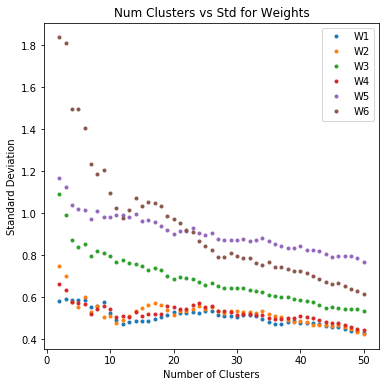

In [13]:
plt.figure(figsize=(6,6))
for i,w in enumerate(ws):
    plt.plot(cluster_sizes, std_test(cluster_sizes, w), '.', label='W{}'.format(i+1))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Standard Deviation')
    plt.title('Num Clusters vs Std for Weights')
    plt.legend() 
plt.savefig('/Users/ahyeon/Desktop/activ misc/std_test.pdf')

In [83]:
def regression_entropy(samples, nbins=10):
    pdf = np.histogram(samples, bins=nbins)[0]/len(samples)
    return scipy.stats.entropy(pdf)

In [113]:
# using regression_entropy
def entropy2(cluster_sizes,data):
    all_vals = []
    for ii,c in enumerate(cluster_sizes):
        vals = []
        for label in np.unique(labels[:,ii]):
            scores = data[labels[:,ii]==label]
            val = regression_entropy(scores)
            vals.append(val)
        avg = np.mean(vals)
        all_vals.append(avg)
    return all_vals

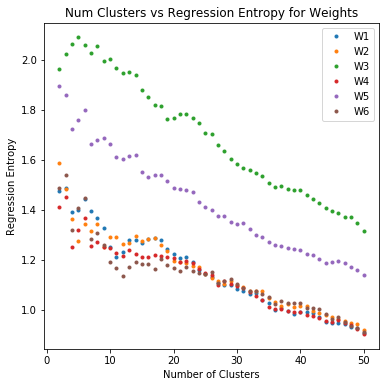

In [118]:
plt.figure(figsize=(6,6))

for i,w in enumerate(ws):
    plt.plot(cluster_sizes, entropy2(cluster_sizes,w), '.', label='W{}'.format(i+1))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Regression Entropy')
    plt.title('Num Clusters vs Regression Entropy for Weights')
    plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/regression_entropy_weights.pdf')